In [46]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.offline as offline
from folium.plugins import HeatMapWithTime
from plotly.subplots import make_subplots
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium import FeatureGroup
import json
import math
import re
from datetime import datetime
import os
import glob
import subprocess
from bs4 import BeautifulSoup as bs
from shapely import wkt
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import unary_union
import geopandas as gpd
from geopandas import GeoSeries
import pyproj
from tqdm import tqdm
from keplergl import KeplerGl
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# tqdm의 pandas전용 메소드를 호출
tqdm.pandas()
# 모든 열이 생략되지 않도록 설정
pd.set_option('display.max_columns', None)
 
# Point를만드는 함수
def make_point(x):
    try:
        return Point(x)
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
# Polygon을 만드는 함수
def make_pol(x):
    try:
        return Polygon(x[0])
    except:
        return Polygon(x[0][0])
    
# Linestring을 만드는 함수
def make_lin(x):
    try:
        return LineString(x)
    except:
        return LineString(x[0])

# 데이터프레임을 GeoPandas 데이터프레임으로 변환하는 함수 정의
def geo_transform(DataFrame) :
    # csv to geopandas
    # lon, lat data를 geometry로 변경
    DataFrame['lat'] = DataFrame['lat'].astype(float)
    DataFrame['lon'] = DataFrame['lon'].astype(float)
    DataFrame['geometry'] = DataFrame.progress_apply(lambda row : Point([row['lon'], row['lat']]), axis=1) # 위도 및 경도롤 GeoPandas Point 객체로 변환
    DataFrame = gpd.GeoDataFrame(DataFrame, geometry='geometry')
    DataFrame.crs = {'init':'epsg:4326'} # geopandas 데이터프레임의 좌표계를 EPSG 4326으로 설정
    DataFrame = DataFrame.to_crs({'init':'epsg:4326'}) # 데이터프레임의 좌표계를 자체 좌표계에서 EPSG 4326으로 변환
    return DataFrame

#### 행정경계

In [47]:
dj_b = pd.read_csv("./대전시_행정경계.csv")
dj_b["geometry"] = dj_b["geometry"].apply(wkt.loads)
dj_b = gpd.GeoDataFrame(dj_b, geometry="geometry")
dj_pol = dj_b.dissolve(by=None)
dj_geo_dic = dict(zip(dj_b['ADM_CD'], dj_b['geometry']))

#### 격자단위(대전)

In [48]:
# 디렉토리 경로
shp_dir1 = "./격자단위/_grid_border_grid_2023_grid_다마_grid_다마"
shp_dir2 = "./격자단위/_grid_border_grid_2023_grid_다바_grid_다바"
shp_dir3 = "./격자단위/_grid_border_grid_2023_grid_라바_grid_라바"

# 디렉토리 내 .shp 파일 찾기
shp_files1 = [f for f in os.listdir(shp_dir1) if f.endswith('.shp')]
shp_files2 = [f for f in os.listdir(shp_dir2) if f.endswith('.shp')]
shp_files3 = [f for f in os.listdir(shp_dir3) if f.endswith('.shp')]

# 첫 번째 .shp 파일 읽기
shp_path = os.path.join(shp_dir1, shp_files1[0])
gdf1 = gpd.read_file(shp_path)
gdf1 = gdf1.to_crs(epsg=4326)

# 두 번째 .shp 파일 읽기
shp_path = os.path.join(shp_dir2, shp_files2[0])
gdf2 = gpd.read_file(shp_path)
gdf2 = gdf2.to_crs(epsg=4326)

# 세 번째 .shp 파일 읽기
shp_path = os.path.join(shp_dir3, shp_files3[0])
gdf3 = gpd.read_file(shp_path)
gdf3 = gdf3.to_crs(epsg=4326)

# 폴리곤 통합
gdf_con = pd.concat([gdf1, gdf2, gdf3]).reset_index(drop=True)
gdf_con.rename(columns={'GRID_1K_CD' : 'grid_cd'}, inplace=True)

# 대전 격자로만 필터링
dj_grid = gdf_con[gdf_con.intersects(dj_pol.unary_union)]

dj_grid_dic = dict(zip(dj_grid['grid_cd'], dj_grid['geometry']))

#### 격자단위(탄소배출)

In [85]:
co2 = pd.read_csv("./격자단위/탄소배출 총괄_전체_격자_1km_2022.csv", encoding='cp949')
dj_co2 = co2[co2['grid_cd'].isin(dj_grid['grid_cd'].tolist())]
dj_co2['geometry'] = dj_co2['grid_cd'].map(dj_grid_dic)

dj_co2 # 이 데이터 프레임에 격자통계 추가할 것

C:\Users\user\AppData\Local\Temp\ipykernel_19252\944018120.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,grid_cd,emissions,geometry
136,라바0013,62.71,POLYGON ((127.50000000000001 36.31434675521236...
144,라바0014,65.21,POLYGON ((127.50000000000001 36.32336221829146...
151,라바0015,1240.97,POLYGON ((127.50000000000001 36.33237766774219...
159,라바0016,922.49,POLYGON ((127.50000000000001 36.34139310356320...
167,라바0017,7123.83,POLYGON ((127.50000000000001 36.35040852575323...
...,...,...,...
105974,다바9924,27.36,POLYGON ((127.48884610188327 36.41351557840409...
105984,다바9925,0.00,POLYGON ((127.48884481266187 36.42253089132852...
105994,다바9926,0.00,POLYGON ((127.48884352286736 36.43154619061015...
106004,다바9927,0.00,POLYGON ((127.48884223249948 36.44056147624773...


#### 주행거리

In [71]:
tot_2022 = pd.read_csv("./2022수정본/tot_2022.csv")
tot_2022["geometry"] = tot_2022["geometry"].apply(wkt.loads)
tot_2022 = gpd.GeoDataFrame(tot_2022, geometry="geometry")

<Axes: >

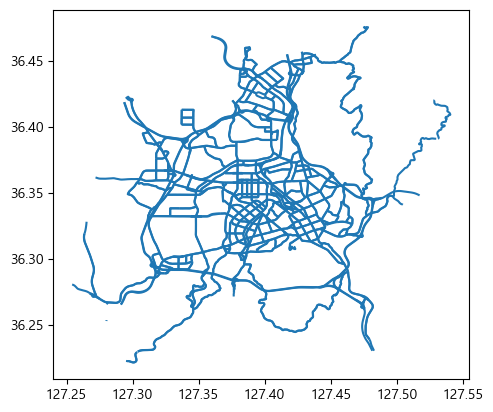

In [68]:
# 1. 대전시 행정동 폴리곤을 하나의 큰 폴리곤으로 합치기
merged_polygon = dj_pol['geometry'].iloc[0]  # GeoSeries에 적용

# 2. 도로 데이터의 라인스트링을 통합 폴리곤 내에서 자르기
tot_2022["geometry"] = tot_2022.geometry.apply(lambda x: x.intersection(merged_polygon))

# 3. 클리핑 후 길이가 0이 된 도로 정보 제거 (빈 도형 방지)
tot_2022 = tot_2022[~tot_2022.geometry.is_empty]

# 4. 결과 시각화
tot_2022.plot()


#### 격자별 교통량 계산

C:\Users\user\AppData\Local\Temp\ipykernel_19252\1448383347.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



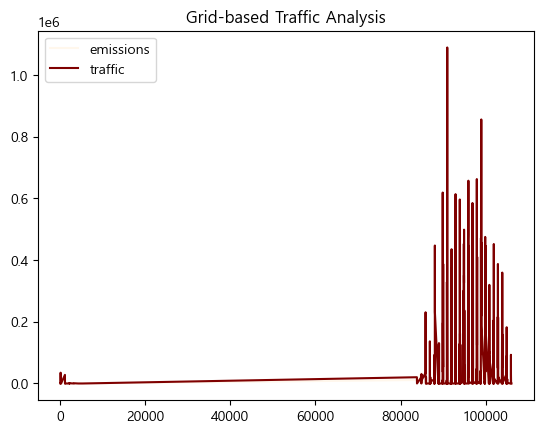

In [89]:

tot_2022["traffic_volume"] = tot_2022["traffic_volume"].fillna(0)

# 격자별 교통량을 저장할 새로운 컬럼 추가
dj_co2["traffic"] = 0.0

# 격자별 교통량 합산 (최적화)
for idx, grid in dj_co2.iterrows():
    # 현재 격자와 겹치는 도로 필터링
    roads_in_grid = tot_2022[tot_2022.geometry.intersects(grid.geometry)].copy()
    
    # 도로가 격자와 겹치는 부분만 유지
    roads_in_grid["clipped_geometry"] = roads_in_grid.geometry.apply(lambda x: x.intersection(grid.geometry))
    
    # 잘린 도로의 길이 계산
    roads_in_grid["clipped_length"] = roads_in_grid["clipped_geometry"].length
    
    # 교통량 합산 (격자 내부 도로들의 교통량 합)
    total_traffic = roads_in_grid["traffic_volume"].sum()
    
    # 최종 교통량을 격자에 저장
    dj_co2.at[idx, "traffic"] = total_traffic

# # 결과 저장 (필요 시)
# dj_co2.to_file("grid_traffic.geojson", driver="GeoJSON")

# 결과 시각화
import matplotlib.pyplot as plt

dj_co2.plot(column="traffic", cmap="OrRd", legend=True)
plt.title("Grid-based Traffic Analysis")
plt.show()


In [ ]:
# 맵 객체 생성 및 데이터 로드
map = KeplerGl(height=1000, width=1500)

# 도시 행정경계
map.add_data(data=tot_2022, name="대전시_온실가스 배출량")

# 도시 행정경계
map.add_data(data=dj_b, name="대전시")

# 맵 출력 및 상세설정
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\user\anaconda3\envs\GIS\lib\site-packages\jupyter_client\session.py:719: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\jupyter_client\session.py:719: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



KeplerGl(data={'대전시_온실가스 배출량': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

In [23]:
map.save_to_html(file_name="대세청_행정구역.html")

Map saved to 대세청_행정구역.html!


In [90]:
# 맵 객체 생성 및 데이터 로드
map = KeplerGl(height=1000, width=1500)

# 도시
dj_co2['geometry'] = dj_co2['geometry'].astype(str)
map.add_data(data=dj_co2, name="대전시_격자별교통량")

# 도시 행정경계
map.add_data(data=dj_b, name="대전시")

# 맵 출력 및 상세설정
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


C:\Users\user\AppData\Local\Temp\ipykernel_19252\2684661461.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



KeplerGl(data={'대전시_격자별교통량': {'index': [136, 144, 151, 159, 167, 175, 184, 193, 203, 212, 222, 259, 268, 1174,…

📊 교통량(traffic)와 온실가스 배출량(emissions)의 피어슨 상관계수: 0.6132


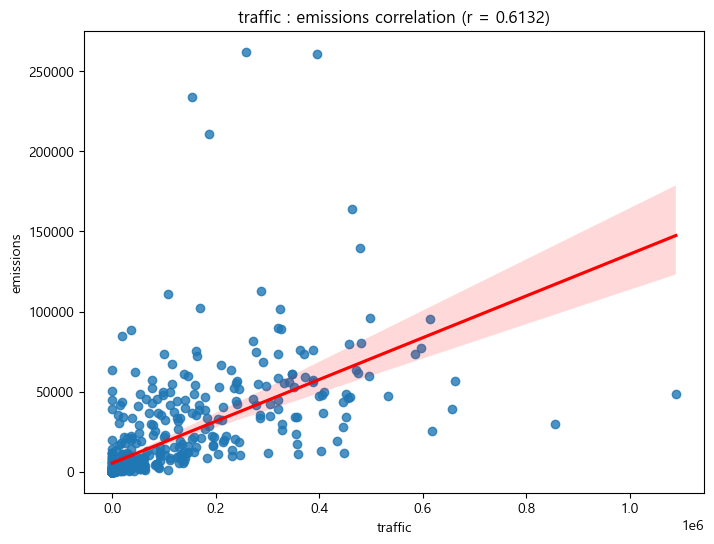

In [91]:
import seaborn as sns

# 상관계수 계산
correlation = dj_co2["traffic"].corr(dj_co2["emissions"], method="pearson")

# 결과 출력
print(f"📊 교통량(traffic)와 온실가스 배출량(emissions)의 피어슨 상관계수: {correlation:.4f}")

# 산점도 + 회귀선 시각화
plt.figure(figsize=(8, 6))
sns.regplot(x=dj_co2["traffic"], y=dj_co2["emissions"], line_kws={"color": "red"})
plt.xlabel("traffic")
plt.ylabel("emissions")
plt.title(f"traffic : emissions correlation (r = {correlation:.4f})")
plt.show()

In [92]:
dj_co2.to_csv('dj_co2_2.csv', index=False)

In [21]:
map.save_to_html(file_name="dj_sj_cj_map.html")

Map saved to dj_sj_cj_map.html!
